<a href="https://colab.research.google.com/github/thanhknguyen/DataScienceGuidedCapstone/blob/master/ML_X_Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Apr 14 07:27:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import files
uploaded = files.upload()

import os,stat
try:    os.mkdir('/root/.kaggle')
except: pass

for fn in uploaded.keys():
  os.chmod(fn,stat.S_IRWXU)
  os.replace(fn,"/root/.kaggle/kaggle.json")

Saving kaggle (1).json to kaggle (1).json


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --force
!unzip -o ./chest-xray-pneumonia.zip "chest_xray/chest_xray/*" -d /dev/shm > /dev/null
!du -h /dev/shm/chest_xray/chest_xray

100% 2.29G/2.29G [00:45<00:00, 53.8MB/s]
100% 2.29G/2.29G [00:45<00:00, 54.5MB/s]
644K	/dev/shm/chest_xray/chest_xray/val/PNEUMONIA
2.4M	/dev/shm/chest_xray/chest_xray/val/NORMAL
3.0M	/dev/shm/chest_xray/chest_xray/val
327M	/dev/shm/chest_xray/chest_xray/train/PNEUMONIA
785M	/dev/shm/chest_xray/chest_xray/train/NORMAL
1.1G	/dev/shm/chest_xray/chest_xray/train
29M	/dev/shm/chest_xray/chest_xray/test/PNEUMONIA
48M	/dev/shm/chest_xray/chest_xray/test/NORMAL
77M	/dev/shm/chest_xray/chest_xray/test
1.2G	/dev/shm/chest_xray/chest_xray


In [ ]:
from PIL import Image
import glob, os
from tqdm import notebook 

outpath = '/dev/shm/data/'
os.system('mkdir -p '+outpath)
os.system('mkdir -p '+outpath+'/PNEUMONIA')
os.system('mkdir -p '+outpath+'/NORMAL')

# get rid of old file structure -- we're gonna partition into train and test ourselves
pneumonia_paths = ['/dev/shm/chest_xray/chest_xray/'+ty+'/PNEUMONIA/' for ty in ['test','val','train']]
normal_paths = ['/dev/shm/chest_xray/chest_xray/'+ty+'/NORMAL/' for ty in ['test','val','train']]

# get all images in pneumonia and normal paths.
pneumonia = ' '.join([' '.join(glob.glob(path+'*.jpeg')) for path in pneumonia_paths]).split()
normal =  ' '.join([' '.join(glob.glob(path+'*.jpeg')) for path in normal_paths]).split()

for n in notebook.trange(len(pneumonia),desc='PNEU'):
  image = pneumonia[n]
  nopath = image[image.rfind('/'):]    
  Image.open(image).resize((256,256),Image.LANCZOS).save(outpath+'PNEUMONIA'+nopath)

for n in notebook.trange(len(normal),desc='NORM'):
  image = normal[n]
  nopath = image[image.rfind('/'):]
  Image.open(image).resize((256,256),Image.LANCZOS).save(outpath+'NORMAL'+nopath)

# check new data size
!du -h /dev/shm/data

PNEU:   0%|          | 0/4273 [00:00<?, ?it/s]

NORM:   0%|          | 0/1583 [00:00<?, ?it/s]

18M	/dev/shm/data/NORMAL
37M	/dev/shm/data/PNEUMONIA
55M	/dev/shm/data


In [ ]:
from fastai.vision import *
data_path = Path('/dev/shm/data').absolute()
model_path = Path('/dev/shm/model').absolute()

data = ImageDataBunch.from_folder(data_path,
                                  valid_pct=0.2,
                                  size=256,
                                  bs=128,
                                  #ds_tfms=get_transforms(), <- This was your data augmentation
                                  no_check=True
                                 ).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, 
                    models.resnet50, 
                    metrics=error_rate, 
                    model_dir=model_path
                    ).to_fp16() # <- this here sets up 16bit weights

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
learn.freeze()
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.448970,0.324433,0.091375,01:30
1,0.251617,0.175640,0.048676,01:21
2,0.157194,0.117935,0.035013,01:21
3,0.095399,0.118642,0.034159,01:22
4,0.058590,0.126348,0.035013,01:21


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


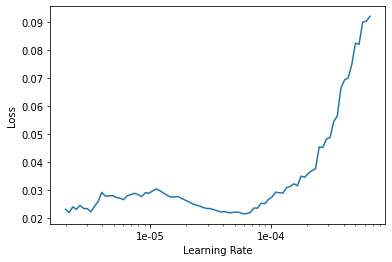

In [ ]:
learn.unfreeze()
learn.lr_find(start_lr=1e-6,end_lr=1e-3,stop_div=False)
learn.recorder.plot()
learn.save(model_path / 'pre') # <- so we can recover from here

In [ ]:
learn.purge()                   # <- maybe not leak GPU memory into Torch
#learn.load(model_path / 'pre')  # <- you can now run this cell multiple times with different learning rates
learn.fit_one_cycle(5, max_lr=3e-6)
learn.export(model_path / 'pneumonia.pkl')
learn.save(model_path / 'pneumonia')

epoch,train_loss,valid_loss,error_rate,time
0,0.024687,0.114035,0.033305,01:52
1,0.022720,0.113675,0.035013,01:52
2,0.018084,0.109471,0.035013,01:52
3,0.016989,0.108310,0.034159,01:51
4,0.012893,0.106124,0.033305,01:51


In [ ]:
# Download files to your local machine
from google.colab import files
files.download(model_path / 'pneumonia.pkl')
files.download(model_path / 'pneumonia.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>